In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats
from get_draws.api import get_draws

In [2]:
output_dirs_3 = ['/ihme/costeffectiveness/results/vivarium_conic_lsff/v3.0_paf_of_one/ethiopia/2020_03_17_14_59_54/count_data/',
             '/ihme/costeffectiveness/results/vivarium_conic_lsff/v3.0_paf_of_one/india/2020_03_17_15_00_02/count_data/',
             '/ihme/costeffectiveness/results/vivarium_conic_lsff/v3.0_paf_of_one/nigeria/2020_03_17_15_00_10/count_data/']

output_dirs_5 = ['/ihme/costeffectiveness/results/vivarium_conic_lsff/v5.0_vitamin_a_fortification/ethiopia/2020_03_26_08_33_10/count_data/',
              '/ihme/costeffectiveness/results/vivarium_conic_lsff/v5.0_vitamin_a_fortification/india/2020_03_26_21_28_29/count_data/',
              '/ihme/costeffectiveness/results/vivarium_conic_lsff/v5.0_vitamin_a_fortification/nigeria/2020_03_24_23_27_55/count_data/']

locations = ['Ethiopia','India','Nigeria']

In [18]:
# get baseline model 5 ACMR by age group

index_columns = ['year', 'age_group', 'sex', 'folic_acid_fortification_group',
       'vitamin_a_fortification_group', 'input_draw', 'scenario']
acmr_model_5 = pd.DataFrame()

for i in list(range(len(output_dirs_5))):
    deaths = pd.read_hdf(output_dirs_5[i] + 'deaths.hdf')
    deaths = deaths.drop(columns='measure').rename(columns={'value':'deaths'})
    pt = pd.read_hdf(output_dirs_5[i] + 'person_time.hdf')
    pt = pt.drop(columns='measure').rename(columns={'value':'person_time'})
    data = deaths.merge(pt, left_on=index_columns, right_on=index_columns)
    data = data.where(data['scenario'] == 'baseline').dropna()
        # note: exclude folic_acid_fortification results here because I tested and 
        # they were identical to baseline results and are not relevant
    data = data.groupby(['scenario','age_group','input_draw'], as_index=False).sum()
    data['acmr'] = data['deaths'] / data['person_time'] * 100_000
    data = data.groupby(['scenario','age_group']).describe().reset_index()
    data['location'] = locations[i]
    acmr_model_5 = acmr_model_5.append(data)

acmr_model_5 = acmr_model_5.drop(columns='scenario').set_index(['location','age_group'])
acmr_model_5['acmr']

count          mean          std           min  \
location age_group                                                        
Ethiopia 1_to_4           25.0     76.586915     4.869298     71.234659   
         early_neonatal   25.0  14502.172858   942.175247  13238.391968   
         late_neonatal    25.0   1320.819468   105.062887   1208.495438   
         post_neonatal    25.0    357.020774    21.889066    327.168876   
India    1_to_4           25.0     29.995929     2.043553     26.103897   
         early_neonatal   25.0  16574.621046   510.822710  15379.043576   
         late_neonatal    25.0   1262.665504    52.209250   1164.334344   
         post_neonatal    25.0    248.376427    10.864515    224.704239   
Nigeria  1_to_4           25.0    226.261140    18.476153    184.195921   
         early_neonatal   25.0  20371.396608  1854.607194  17434.971309   
         late_neonatal    25.0   1579.588855   145.046395   1332.199334   
         post_neonatal    25.0    629.159920    49.144481    533.314815   

                                  25%           50%           75%  \
location age_group                                                  
Ethiopia 1_to_4             73.354292     74.913626     78.312390   
         early_neonatal  13962.522451  14407.112772  14706.598850   
         late_neonatal    1238.366069   1312.700945   1347.506283   
         post_neonatal     340.624136    354.622539    365.184088   
India    1_to_4             28.823557     29.927316     31.079830   
         early_neonatal  16333.222816  16684.939831  16766.577268   
         late_neonatal    1233.979095   1252.290707   1297.235758   
         post_neonatal     245.080715    249.670252    254.032031   
Nigeria  1_to_4            211.554945    231.192997    240.519504   
         early_neonatal  19254.377724  20096.547517  21192.593464   
         late_neonatal    1512.909945   1578.078194   1639.718713   
         post_neonatal     589.766822    634.779911    663.351592   

                                  max  
location age_group                     
Ethiopia 1_to_4             91.173349  
         early_neonatal  17283.588580  
         late_neonatal    1683.848609  
         post_neonatal     412.891074  
India    1_to_4             33.582341  
         early_neonatal  17787.898019  
         late_neonatal    1380.143622  
         post_neonatal     271.851107  
Nigeria  1_to_4            266.730324  
         early_neonatal  23857.602060  
         late_neonatal    1847.806570  
         post_neonatal     721.985969

In [9]:
# get model 3 ACMR by age group

index_columns = ['year', 'age_group', 'sex', 'input_draw']
acmr_model_3 = pd.DataFrame()

for i in list(range(len(output_dirs_3))):
    deaths = pd.read_hdf(output_dirs_3[i] + 'deaths.hdf')
    deaths = deaths.drop(columns='measure').rename(columns={'value':'deaths'})
    pt = pd.read_hdf(output_dirs_3[i] + 'person_time.hdf')
    pt = pt.drop(columns='measure').rename(columns={'value':'person_time'})
    data = deaths.merge(pt, left_on=index_columns, right_on=index_columns)
        # note: exclude folic_acid_fortification results here because I tested and 
        # they were identical to baseline results and are not relevant
    data = data.groupby(['age_group','input_draw'], as_index=False).sum()
    data['acmr'] = data['deaths'] / data['person_time'] * 100_000
    data = data.groupby(['age_group']).describe().reset_index()
    data['location'] = locations[i]
    acmr_model_3 = acmr_model_3.append(data)

acmr_model_3 = acmr_model_3.set_index(['location','age_group'])
acmr_model_3['acmr']

count          mean          std           min  \
location age_group                                                        
Ethiopia 1_to_4           25.0    214.627174    14.080543    198.745324   
         early_neonatal   25.0  14599.366374   946.651625  13332.004119   
         late_neonatal    25.0   1340.087165   106.551327   1227.077126   
         post_neonatal    25.0    406.538588    24.422302    371.579779   
India    1_to_4           25.0     91.213031     6.231012     79.327111   
         early_neonatal   25.0  16630.557477   514.561747  15474.141198   
         late_neonatal    25.0   1278.086648    55.980240   1176.727615   
         post_neonatal    25.0    281.807449    12.152908    257.645573   
Nigeria  1_to_4           25.0    620.816357    50.435434    503.458350   
         early_neonatal   25.0  20494.030574  1862.792180  17564.840726   
         late_neonatal    25.0   1602.350342   146.248721   1351.618361   
         post_neonatal    25.0    710.770519    54.457598    610.077011   

                                  25%           50%           75%  \
location age_group                                                  
Ethiopia 1_to_4            205.994926    210.255988    219.049087   
         early_neonatal  14038.132542  14490.408931  14791.670064   
         late_neonatal    1254.614089   1330.461736   1367.537303   
         post_neonatal     389.635981    405.261134    416.689524   
India    1_to_4             87.054615     91.921273     95.290948   
         early_neonatal  16393.310796  16713.159580  16881.103051   
         late_neonatal    1240.235438   1266.464224   1311.272727   
         post_neonatal     279.293030    282.473970    287.885475   
Nigeria  1_to_4            580.686470    634.419359    660.604545   
         early_neonatal  19369.534674  20198.304062  21316.956088   
         late_neonatal    1537.489815   1597.272832   1656.301614   
         post_neonatal     671.351251    719.336670    748.862282   

                                  max  
location age_group                     
Ethiopia 1_to_4            256.224590  
         early_neonatal  17383.368998  
         late_neonatal    1708.860889  
         post_neonatal     470.474686  
India    1_to_4            102.252591  
         early_neonatal  17832.884329  
         late_neonatal    1403.723524  
         post_neonatal     307.783236  
Nigeria  1_to_4            726.590649  
         early_neonatal  24005.414506  
         late_neonatal    1867.978150  
         post_neonatal     811.088774

In [42]:
# get artifact ACMR by age group
# NOTE: taking average between sexes rather than stratify by sex
master_acmr = pd.DataFrame()
col_list = ['location','sex','age_start','age_end','year_start','year_end']
for i in ['ethiopia','india','nigeria']:
    art = Artifact('/share/costeffectiveness/artifacts/vivarium_conic_lsff/' + i + '.hdf', 
               filter_terms=['year_start == 2017', 'age_start < 5'])
    data = art.load('cause.all_causes.cause_specific_mortality_rate')
    data_mean = pd.DataFrame(data.mean(axis=1)).reset_index().rename(columns={0:'value'})
    data_lower = pd.DataFrame(data.quantile(q=0.025, axis=1)).reset_index().rename(columns={0.025:'lower'})
    data_upper = pd.DataFrame(data.quantile(q=0.975, axis=1)).reset_index().rename(columns={0.975:'upper'})
    data = data_mean.merge(data_lower, right_on=col_list, left_on=col_list)
    data = data.merge(data_upper, right_on=col_list, left_on=col_list)
    data['location'] = i.capitalize()
    data['age_group'] = 0
    data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                               np.where(data['age_end'] == 1, 'post_neonatal',
                                        np.where(data['age_start'] == 1, '1_to_4', 
                                                'late_neonatal')))
    data['value'] = data['value'] * 100_000
    data['upper'] = data['upper'] * 100_000
    data['lower'] = data['lower'] * 100_000
    master_acmr = master_acmr.append(data)
master_acmr = master_acmr.groupby(['location','age_group']).mean()
master_acmr = master_acmr[['value','upper','lower']]
master_acmr

value          upper          lower
location age_group                                                  
Ethiopia 1_to_4             378.886526     421.652397     342.517091
         early_neonatal   99311.515095  111412.264680   89365.995066
         late_neonatal     9298.075910   10443.656134    8362.663882
         post_neonatal     1813.206821    2031.066507    1633.970120
India    1_to_4             152.950723     172.663531     136.261682
         early_neonatal   95758.152804  101899.469070   90403.103021
         late_neonatal     8403.841227    8943.412869    7922.173872
         post_neonatal     1373.140133    1465.852031    1293.020888
Nigeria  1_to_4            1129.896615    1359.373104     933.792709
         early_neonatal  143395.680444  175968.826223  116253.362148
         late_neonatal    12856.314771   15952.647355   10279.145164
         post_neonatal     3152.033247    3832.505335    2579.129265

In [44]:
master_acmr = master_acmr.reset_index().sort_values(by='location')
acmr_model_5 = acmr_model_5.reset_index().sort_values(by='location')
acmr_model_3 = acmr_model_3.reset_index().sort_values(by='location')

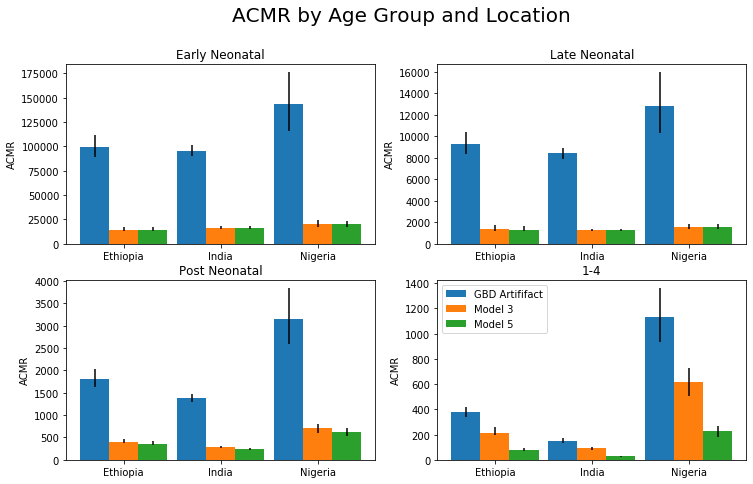

In [45]:
# define plotting function

barWidth = 0.3

fig,axs = plt.subplots(2,2)

model_5 = acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'early_neonatal').dropna().values
model_5_min = (acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'early_neonatal').dropna().values 
               - acmr_model_5['acmr','min'].where(acmr_model_5['age_group'] == 'early_neonatal').dropna().values)
model_5_max = (acmr_model_5['acmr','max'].where(acmr_model_5['age_group'] == 'early_neonatal').dropna().values 
               - acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'early_neonatal').dropna().values)

model_3 = acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'early_neonatal').dropna().values
model_3_min = (acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'early_neonatal').dropna().values 
               - acmr_model_3['acmr','min'].where(acmr_model_3['age_group'] == 'early_neonatal').dropna().values)
model_3_max = (acmr_model_3['acmr','max'].where(acmr_model_3['age_group'] == 'early_neonatal').dropna().values 
               - acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'early_neonatal').dropna().values)

art = master_acmr['value'].where(master_acmr['age_group'] == 'early_neonatal').dropna().values
art_min = (master_acmr['value'].where(master_acmr['age_group'] == 'early_neonatal').dropna().values 
               - master_acmr['lower'].where(master_acmr['age_group'] == 'early_neonatal').dropna().values)
art_max = (master_acmr['upper'].where(master_acmr['age_group'] == 'early_neonatal').dropna().values 
               - master_acmr['value'].where(master_acmr['age_group'] == 'early_neonatal').dropna().values)

a = np.arange(len(model_5))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
axs[0,0].bar(a, art, yerr=[art_min, art_max], width=barWidth)
axs[0,0].bar(b, model_3, yerr=[model_3_min, model_3_max], width=barWidth)
axs[0,0].bar(c, model_5, yerr=[model_5_min, model_5_max], width=barWidth)
axs[0,0].set_title('Early Neonatal')

model_5 = acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'late_neonatal').dropna().values
model_5_min = (acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'late_neonatal').dropna().values 
               - acmr_model_5['acmr','min'].where(acmr_model_5['age_group'] == 'late_neonatal').dropna().values)
model_5_max = (acmr_model_5['acmr','max'].where(acmr_model_5['age_group'] == 'late_neonatal').dropna().values 
               - acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'late_neonatal').dropna().values)

model_3 = acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'late_neonatal').dropna().values
model_3_min = (acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'late_neonatal').dropna().values 
               - acmr_model_3['acmr','min'].where(acmr_model_3['age_group'] == 'late_neonatal').dropna().values)
model_3_max = (acmr_model_3['acmr','max'].where(acmr_model_3['age_group'] == 'late_neonatal').dropna().values 
               - acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'late_neonatal').dropna().values)

art = master_acmr['value'].where(master_acmr['age_group'] == 'late_neonatal').dropna().values
art_min = (master_acmr['value'].where(master_acmr['age_group'] == 'late_neonatal').dropna().values 
               - master_acmr['lower'].where(master_acmr['age_group'] == 'late_neonatal').dropna().values)
art_max = (master_acmr['upper'].where(master_acmr['age_group'] == 'late_neonatal').dropna().values 
               - master_acmr['value'].where(master_acmr['age_group'] == 'late_neonatal').dropna().values)

a = np.arange(len(model_5))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
axs[0,1].bar(a, art, yerr=[art_min, art_max], width=barWidth)
axs[0,1].bar(b, model_3, yerr=[model_3_min, model_3_max], width=barWidth)
axs[0,1].bar(c, model_5, yerr=[model_5_min, model_5_max], width=barWidth)
axs[0,1].set_title('Late Neonatal')

model_5 = acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'post_neonatal').dropna().values
model_5_min = (acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'post_neonatal').dropna().values 
               - acmr_model_5['acmr','min'].where(acmr_model_5['age_group'] == 'post_neonatal').dropna().values)
model_5_max = (acmr_model_5['acmr','max'].where(acmr_model_5['age_group'] == 'post_neonatal').dropna().values 
               - acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == 'post_neonatal').dropna().values)

model_3 = acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'post_neonatal').dropna().values
model_3_min = (acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'post_neonatal').dropna().values 
               - acmr_model_3['acmr','min'].where(acmr_model_3['age_group'] == 'post_neonatal').dropna().values)
model_3_max = (acmr_model_3['acmr','max'].where(acmr_model_3['age_group'] == 'post_neonatal').dropna().values 
               - acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == 'post_neonatal').dropna().values)

art = master_acmr['value'].where(master_acmr['age_group'] == 'post_neonatal').dropna().values
art_min = (master_acmr['value'].where(master_acmr['age_group'] == 'post_neonatal').dropna().values 
               - master_acmr['lower'].where(master_acmr['age_group'] == 'post_neonatal').dropna().values)
art_max = (master_acmr['upper'].where(master_acmr['age_group'] == 'post_neonatal').dropna().values 
               - master_acmr['value'].where(master_acmr['age_group'] == 'post_neonatal').dropna().values)

a = np.arange(len(model_5))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
axs[1,0].bar(a, art, yerr=[art_min, art_max], width=barWidth)
axs[1,0].bar(b, model_3, yerr=[model_3_min, model_3_max], width=barWidth)
axs[1,0].bar(c, model_5, yerr=[model_5_min, model_5_max], width=barWidth)
axs[1,0].set_title('Post Neonatal')


model_5 = acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == '1_to_4').dropna().values
model_5_min = (acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == '1_to_4').dropna().values 
               - acmr_model_5['acmr','min'].where(acmr_model_5['age_group'] == '1_to_4').dropna().values)
model_5_max = (acmr_model_5['acmr','max'].where(acmr_model_5['age_group'] == '1_to_4').dropna().values 
               - acmr_model_5['acmr','mean'].where(acmr_model_5['age_group'] == '1_to_4').dropna().values)

model_3 = acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == '1_to_4').dropna().values
model_3_min = (acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == '1_to_4').dropna().values 
               - acmr_model_3['acmr','min'].where(acmr_model_3['age_group'] == '1_to_4').dropna().values)
model_3_max = (acmr_model_3['acmr','max'].where(acmr_model_3['age_group'] == '1_to_4').dropna().values 
               - acmr_model_3['acmr','mean'].where(acmr_model_3['age_group'] == '1_to_4').dropna().values)

art = master_acmr['value'].where(master_acmr['age_group'] == '1_to_4').dropna().values
art_min = (master_acmr['value'].where(master_acmr['age_group'] == '1_to_4').dropna().values 
               - master_acmr['lower'].where(master_acmr['age_group'] == '1_to_4').dropna().values)
art_max = (master_acmr['upper'].where(master_acmr['age_group'] == '1_to_4').dropna().values 
               - master_acmr['value'].where(master_acmr['age_group'] == '1_to_4').dropna().values)

a = np.arange(len(model_5))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
axs[1,1].bar(a, art, yerr=[art_min, art_max], width=barWidth)
axs[1,1].bar(b, model_3, yerr=[model_3_min, model_3_max], width=barWidth)
axs[1,1].bar(c, model_5, yerr=[model_5_min, model_5_max], width=barWidth)
axs[1,1].set_title('1-4')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model_5))], 
         xticklabels=['Ethiopia','India','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='ACMR')

plt.legend(['GBD Artififact','Model 3','Model 5'], loc='best')
plt.suptitle('ACMR by Age Group and Location',x=0.9, y=1.7,fontsize=20)
plt.subplots_adjust(right=1.7, top=1.5)
#plt.tight_layout()

# CONCLUSION:

We are underestimating ACMR in our model relative to GBD artifact. This may be due to several reasons (LRI birth prevalence, LBWSG strategy)

Additionally, our model 5 results are further underestimating our model 3 results compared to GBD data among the post neonatal and 1-4 age groups, but not the early/late neonatal age groups. Because the only difference between model 3 and 5 is adding the scenarios, this isse seems to be due to the vitamin a scenarios. Additionally, given that vitamin A fortification only affects the postnatal and 1-4 age groups, it appears that it could be an issue caused by the baseline coverage calibration. 